In [1]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold
from sklearn import svm
from sklearn import preprocessing
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from prettytable import PrettyTable
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error

# Part 1. Data exploration

In [2]:
from sklearn import datasets ## imports datasets from scikit-learn
data = datasets.load_boston() ## loads Boston dataset from datasets
print(data.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Data loading and exploration. I transformed the data to treat crime_rate as a output variable as compared to MEDV. 

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
data = pd.read_csv(url, sep='\s+', header = None)
data.columns = ["CRIME_RATE","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT","MEDV"] 
data = data[["ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT","MEDV", "CRIME_RATE"]]
numrows, numcols = data.shape
print("total data points:",numrows)
print("total features:",numcols)
data.head()

total data points: 506
total features: 14


,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CRIME_RATE
0,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0,0.00632
1,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6,0.02731
2,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7,0.02729
3,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4,0.03237
4,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2,0.06905


some preliminary statistics about each variable in the dataset

In [4]:
data.describe()

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CRIME_RATE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806,3.613524
std,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104,8.601545
min,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000,0.006320
25%,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000,0.082045
50%,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000,0.256510
75%,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000,3.677082
max,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000,88.976200


Checking whether there are missing values in the data. Luckily there are not.

In [5]:
lis = pd.isnull(data).any()
lis = list(lis)
if True in lis:
    print("missing values")
else:
    print("No missing values")

No missing values


##  Correlation among every pair of features

In [6]:
data.corr(method='pearson')

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CRIME_RATE
ZN,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445,-0.200469
INDUS,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725,0.406583
CHAS,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260,-0.055892
NOX,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321,0.420972
RM,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360,-0.219247
AGE,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955,0.352734
DIS,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929,-0.379670
RAD,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626,0.625505
TAX,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536,0.582764
PTRATIO,-0.391679,0.383248,-0.121515,0.188933,-0.355501,0.261515,-0.232471,0.464741,0.460853,1.000000,-0.177383,0.374044,-0.507787,0.289946


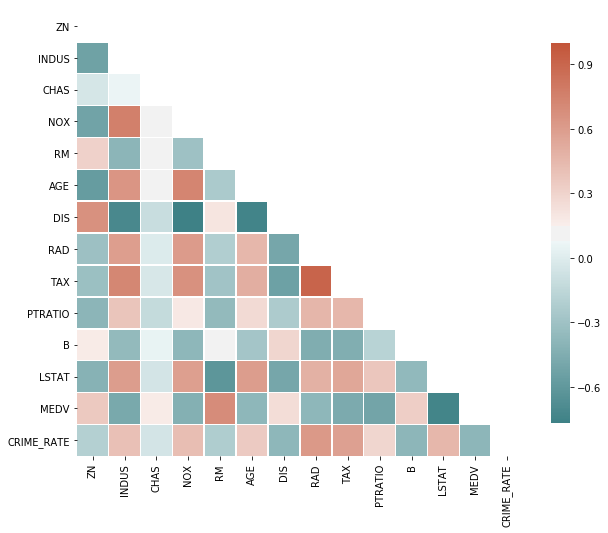

In [7]:
pea_correlation= data.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(pea_correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 20, n=3, as_cmap=True)
#sns.corrplot(df, cmap=sns.diverging_palette(250, 10, n=3, as_cmap=True))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pea_correlation, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

- There does not seem to be very high correlation (positive or negative) between each feature to the output variable. 
- RAD, TAX, and LSTAT seems to have good positive correlation with crime_rate
- B, MEDV seems to have negative correlation with Crime Rate.

Checking distribution of each variable. CRIME_RATE seems to follow poison distribution. The values are not normally distrbuted. Data seems to be skewed.

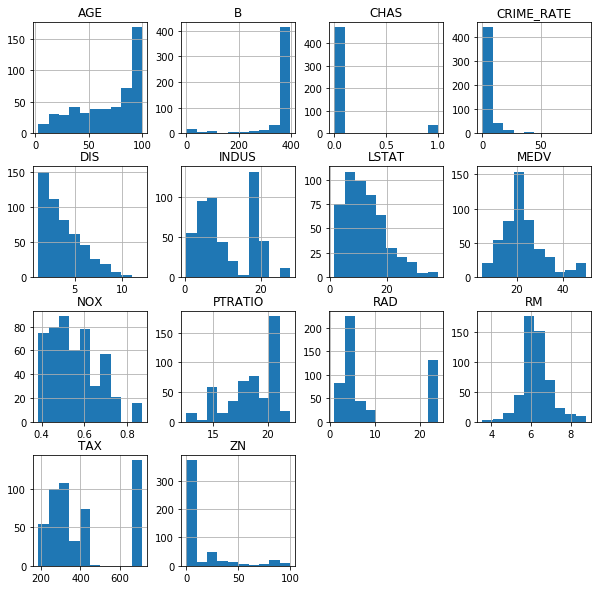

In [8]:
data.hist(figsize=(10,10), bins=10)
plt.show()

## Relationship among features and target variable

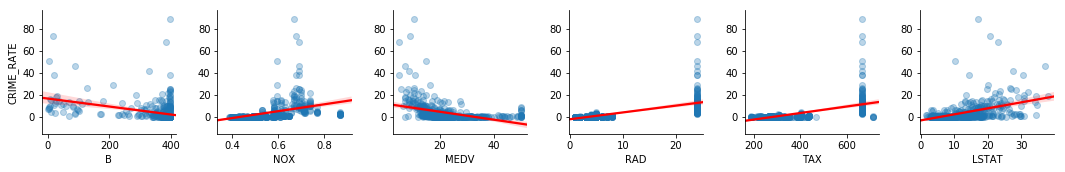

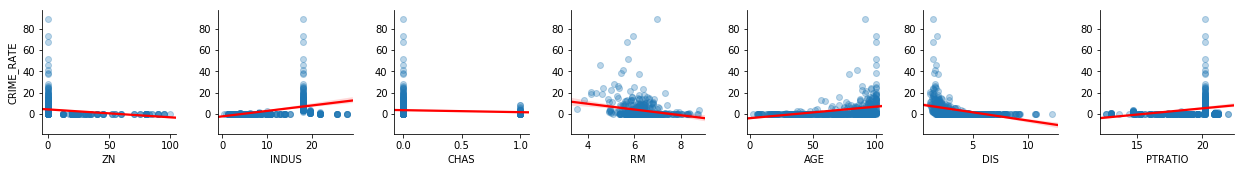

In [9]:
#X_scaled = preprocessing.scale(X_train)
#data[["RAD","MEDV", "CRIME_RATE"]]

sns.pairplot(data, 
                  y_vars=['CRIME_RATE'],
                  x_vars=["B", "NOX", "MEDV", "RAD", "TAX", "LSTAT"],
             kind="reg", plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}})
plt.show()

sns.pairplot(data, 
                  y_vars=['CRIME_RATE'],
                  x_vars=['ZN', 'INDUS', 'CHAS', 'RM', 'AGE', 'DIS','PTRATIO'],
             kind="reg", plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}})
plt.show()

There does not seem to be a linear relation between variables and target. So, it is likely that linear model will not be a good choice. But here we are assuming the features are independent. 

In [10]:
#normalized_df=preprocessing.normalize(data)    #(data-data.min())/(data.max()-data.min())
X = data.drop('CRIME_RATE', axis = 1)
Y = data['CRIME_RATE']
X.head()

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Using SKlearn library for feature selection

## Univariate feature selection

This method examines each feature individually and see the relationship of the feature with the response variable and assign a strength score to it. The higher the score is, the stronger the relationship is. This method is simple to understand but might not be the optimal for feature selection since it only considers each variable separately. chi2 cannot be used for feature selection with regression data hence using f_regression


In [11]:
# feature extraction
test = SelectKBest(score_func=sk.feature_selection.f_regression, k=3)

fit = test.fit(X, Y)
# summarize scores
np.set_printoptions(precision=3)

print(sorted(zip(map(lambda x: round(x, 4), fit.scores_), data.columns), reverse=True))
#top 3 features are 
#RAD, TAX, LSTAT

[(323.93520000000001, 'RAD'), (259.19029999999998, 'TAX'), (132.0351, 'LSTAT'), (108.5553, 'NOX'), (99.816999999999993, 'INDUS'), (89.486099999999993, 'MEDV'), (87.739800000000002, 'B'), (84.887799999999999, 'DIS'), (71.619399999999999, 'AGE'), (46.259500000000003, 'PTRATIO'), (25.450199999999999, 'RM'), (21.102799999999998, 'ZN'), (1.5793999999999999, 'CHAS')]


## Recursive feature selection

This method selects features by recursively considering smaller and smaller sets of features. Least important features are pruned from current set of features. It is recursively repeated on the pruned set until the desired number of features to select is eventually reached. In our case, 3 features

In [12]:
model = LinearRegression()
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)

print(sorted(zip(map(lambda x: round(x, 4), fit.ranking_), data.columns), reverse=False))

#'CHAS','NOX', 'RM', 'DIS','RAD', - before normalization
# "DIS", "RAD", "MEDV", "ZN", "NOX" - after normalization whole data
# "CHAS","NOX","RAD","DIS","LSTAT" -- after normalizing only variables not target

[(1, 'CHAS'), (1, 'NOX'), (1, 'RM'), (2, 'RAD'), (3, 'DIS'), (4, 'PTRATIO'), (5, 'MEDV'), (6, 'LSTAT'), (7, 'INDUS'), (8, 'ZN'), (9, 'B'), (10, 'TAX'), (11, 'AGE')]


Features selected using RFE are CHAS, NOX and RM which are no where close to what we got using univariate. RFE is choosing features by running linear regression on the dataset which might be misleading because we do not know which model would fit the data most.

## Random Forest Regressor

This method is more robust and is popular approach for feature ranking. Variance is the measure used to compute the importance of each feature. But this method based on impurity reduction might create bias towards preferring variables with more categories.

In [13]:
names = data.columns
rf = RandomForestRegressor()
rf.fit(X, Y)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.30959999999999999, 'RAD'), (0.26989999999999997, 'MEDV'), (0.19550000000000001, 'DIS'), (0.10249999999999999, 'B'), (0.046100000000000002, 'RM'), (0.0304, 'LSTAT'), (0.029000000000000001, 'AGE'), (0.016500000000000001, 'NOX'), (0.00029999999999999997, 'PTRATIO'), (0.0001, 'TAX'), (0.0001, 'INDUS'), (0.0001, 'CHAS'), (0.0, 'ZN')]


Top 3 features selected using RFR are RAD, MEDV and RM. 

For this assignment, I will consider the feature chosen from Random Forest method and train a model on the dataset.

# Part 2. Predictive modeling

Since all variables are on different scale, I normalized the features to be in a [0,1] range

In [14]:
data = data[["RAD","MEDV", "RM","CRIME_RATE"]]
X = data.drop('CRIME_RATE', axis = 1)
Y = data['CRIME_RATE']
X.head()

,RAD,MEDV,RM
0,1,24.0,6.575
1,2,21.6,6.421
2,2,34.7,7.185
3,3,33.4,6.998
4,3,36.2,7.147


In [15]:
norm_X = preprocessing.normalize(X) #normalize the variables
X_train, X_test, Y_train, Y_test = train_test_split(norm_X, Y, test_size = 0.2, random_state=8)
print(X_train)

[[ 0.792  0.591  0.153]
 [ 0.079  0.985  0.155]
 [ 0.064  0.972  0.228]
 ..., 
 [ 0.298  0.91   0.288]
 [ 0.247  0.923  0.295]
 [ 0.823  0.521  0.228]]


## Evaluate models on Normalized Data

In [24]:
#scalar = StandardScaler()
#X_train = scalar.fit_transform(X_train)
#X_test = scalar.transform(X_test)

model_list = []
# Linear algorithms
model_list.append(('LR', LinearRegression()))
model_list.append(('LASSO', Lasso()))
model_list.append(('KR', KernelRidge(alpha=1.0)))
# Nonlinear algorithms

model_list.append(('CART', DecisionTreeRegressor()))
model_list.append(('SVR RBF', SVR(kernel='rbf', C=1e3, gamma=0.1)))
model_list.append(('SVR LINEAR', SVR(kernel='linear', C=1e3)))
model_list.append(('SVR POLY Deg=2', SVR(kernel='poly', C=1e3, degree=2)))
# evaluate each model 
results = []
names = []

t = PrettyTable(['Name', 'TRAIN MSE', 'TRAIN STD', 'TEST MSE', 'TEST R2 SCORE'])
for name, model in model_list:
    kfold = KFold(n_splits=10, random_state=8)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    test_MSE = sk.metrics.mean_squared_error(Y_test, Y_pred) #greater_is_better=False
    test_r2_score = sk.metrics.r2_score(Y_test, Y_pred)
    #print("MSE:",mse)
    t.add_row([name, np.mean(cv_results), np.std(cv_results), test_MSE, test_r2_score])
print(t) #greater_is_better=True

+----------------+----------------+---------------+---------------+----------------+
|      Name      |   TRAIN MSE    |   TRAIN STD   |    TEST MSE   | TEST R2 SCORE  |
+----------------+----------------+---------------+---------------+----------------+
|       LR       |  -49.69494663  | 43.7575232814 | 23.8114377894 | 0.545141776463 |
|     LASSO      | -50.3942904176 | 47.0953369727 | 23.9093673379 | 0.543271076304 |
|       KR       | -62.4342848478 | 50.1775946236 | 35.3925632189 | 0.323913214542 |
|      CART      | -95.962657195  | 70.4830992498 | 20.0719088488 | 0.61657616467  |
|    SVR RBF     | -39.6939163186 | 46.5345260071 | 29.1291382607 | 0.443560351138 |
|   SVR LINEAR   | -55.1633083462 | 51.0882671636 | 28.4361068182 | 0.456798991056 |
| SVR POLY Deg=2 | -54.6611773438 | 47.6011716878 | 30.3167420963 | 0.42087413724  |
+----------------+----------------+---------------+---------------+----------------+


In [18]:
# plt.scatter(lm.predict(X_train), lm.predict(X_train) - Y_train, c='b', s=40,alpha=0.5)
# plt.scatter(lm.predict(X_test), lm.predict(X_test) - Y_test, c='g', s=40)
# plt.hlines(y=0, xmin=0, xmax=50)
# plt.title('Residual graph using training (blue) and testing (green) data')
# plt.ylabel('Residuals')
# plt.show()

## Evaluate models on Standardized Data

In [19]:
X.head()

,RAD,MEDV,RM
0,1,24.0,6.575
1,2,21.6,6.421
2,2,34.7,7.185
3,3,33.4,6.998
4,3,36.2,7.147


In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=8)
#scalar = StandardScaler()
#X_train = scalar.fit_transform(X_train)
#X_test = scalar.transform(X_test)
X_train.head()

,RAD,MEDV,RM
412,24,17.9,4.628
195,4,50.0,7.875
197,2,30.3,7.107
92,4,22.9,6.442
146,5,15.6,5.628


In [25]:
scalar = StandardScaler()
pipeline_list = []
pipeline_list.append(('LR', Pipeline([('Scaler', scalar), ('LR', LinearRegression())])))
pipeline_list.append(('LASSO', Pipeline([('Scaler', scalar), ('LASSO', Lasso())])))
pipeline_list.append(('Kernel Ridge', Pipeline([('Scaler', scalar), ('Kernel Ridge',KernelRidge(alpha=1.0))])))
pipeline_list.append(('Decision Tree Regr',Pipeline([('Scaler', scalar), ('Decision Tree Regr',DecisionTreeRegressor())])))   
pipeline_list.append(('SVR RBF', Pipeline([('Scaler', scalar), ('SVR RBF',SVR(kernel='rbf', C=1e3, gamma=0.1))])))  
pipeline_list.append(('SVR LINEAR', Pipeline([('Scaler', scalar), ('SVR LINEAR',SVR(kernel='linear', C=1e3))])))
pipeline_list.append(('SVR POLY Deg=2', Pipeline([('Scaler', scalar), ('SVR POLY Deg=2',SVR(kernel='poly', C=1e3, degree=2))])))

results = []
names = []
t = PrettyTable(['Name', 'TRAIN MSE', 'TRAIN STD', 'TEST MSE', 'TEST R2 SCORE'])

for name, model in pipeline_list:
    kfold = KFold(n_splits=10, random_state=0)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    test_MSE = sk.metrics.mean_squared_error(Y_test, Y_pred) #greater_is_better=False
    test_r2_score = sk.metrics.r2_score(Y_test, Y_pred)
    #print("MSE:",mse)
    t.add_row([name, np.mean(cv_results), np.std(cv_results), test_MSE, test_r2_score])
    
print(t)   

+--------------------+----------------+---------------+---------------+----------------+
|        Name        |   TRAIN MSE    |   TRAIN STD   |    TEST MSE   | TEST R2 SCORE  |
+--------------------+----------------+---------------+---------------+----------------+
|         LR         |  -49.69494663  | 43.7575232814 | 23.8114377894 | 0.545141776463 |
|       LASSO        | -50.3839126053 | 47.0690985983 | 23.9093673379 | 0.543271076304 |
|    Kernel Ridge    | -62.507065626  |  50.586299795 | 35.3925632189 | 0.323913214542 |
| Decision Tree Regr | -84.2094684634 | 72.7661428417 | 20.2829199889 | 0.612545322299 |
|      SVR RBF       | -39.7947748684 | 46.8023220407 | 29.1291382607 | 0.443560351138 |
|     SVR LINEAR     | -55.1621284121 | 51.0889902029 | 28.4361068182 | 0.456798991056 |
|   SVR POLY Deg=2   | -54.8320622527 | 47.8944674383 | 30.3167420963 | 0.42087413724  |
+--------------------+----------------+---------------+---------------+----------------+


## References

https://towardsdatascience.com/machine-learning-with-python-easy-and-robust-method-to-fit-nonlinear-data-19e8a1ddbd49

https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9

https://machinelearningmastery.com/feature-selection-machine-learning-python/

https://machinelearningmastery.com/feature-selection-machine-learning-python/

http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/

http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

http://blog.minitab.com/blog/adventures-in-statistics-2/when-is-it-crucial-to-standardize-the-variables-in-a-regression-model

https://machinelearningmastery.com/train-final-machine-learning-model/

https://stats.stackexchange.com/questions/52274/how-to-choose-a-predictive-model-after-k-fold-cross-validation

https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/metrics/scorer.py#L472